In [2]:
from astropy import convolution
import numpy as np
import matplotlib.pyplot as plt
import re
from PIL import Image

In [8]:
ccd_px_side_length_micron = 3.8
x_example = 6.38379
y_example = 8.53834
ang0 = np.rad2deg(np.arctan2(y_example,x_example))

def four_px(w_px,h_px,wid,hei):
    lst = []
    if (w_px <0 or w_px >= wid or h_px < 0 or h_px >= hei):
        return lst
    wf = np.floor(w_px)
    wc = np.ceil(w_px)
    hf = np.floor(h_px)
    hc = np.ceil(h_px)
    if np.allclose(w_px,wf): 
        w_floor_res = 1
        w_ceil_res = 0
    else: 
        w_floor_res = np.round(w_px - wf,3)
        w_ceil_res = np.round(wc - w_px,3)
    if np.allclose(h_px,hf): 
        h_floor_res = 1
        h_ceil_res = 0
    else: 
        h_floor_res = np.round(h_px - hf,3)
        h_ceil_res = np.round(hc - h_px,3)    

    if (wf >= 0 and hf >= 0):
        lst.append([wf ,hf ,w_floor_res*h_floor_res])
    if (wc < wid and hf >= 0):
        lst.append([wc ,hf ,w_ceil_res*h_floor_res])
    if (wf >= 0 and hc < hei):
        lst.append([wf ,hc ,w_floor_res*h_ceil_res])
    if (wc < wid and hc < hei):
        lst.append([wc , hc ,w_ceil_res*h_ceil_res])
    return lst

def rotate(mat,ang):
    cw = int(mat.shape[1]/2 -1)
    ch = int(mat.shape[0]/2 -1)

    mat2 = np.zeros(mat.shape)
    ang = np.deg2rad(ang)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            jj = cw + np.cos(ang)*(j-cw) - np.sin(ang)*(i-ch)
            ii = ch + np.sin(ang)*(j-cw) + np.cos(ang)*(i-ch)
            lst = four_px(np.round(jj,3),np.round(ii,3),mat.shape[1],mat.shape[0])
            for ls in lst:
                 mat2[int(ls[1]),int(ls[0])] += ls[2] * mat[i,j]
    return mat2

def rot(psf,ang,ang0):
    im = Image.fromarray(psf)
    im = im.rotate(ang0-ang)
    return np.array(im)

def micind_to_pxind(w_ind,h_ind,cw_mic,ch_mic,cw_mic_ind,ch_mic_ind,cw_px_ind,ch_px_ind,spacing_micron):
    w_mic = cw_mic + (w_ind - cw_mic_ind)*spacing_micron
    h_mic = ch_mic + (h_ind - ch_mic_ind)*spacing_micron
    w_px = w_mic/ccd_px_side_length_micron
    h_px = h_mic/ccd_px_side_length_micron
    w_px_ind = int(w_px-cw_mic/ccd_px_side_length_micron) + cw_px_ind 
    h_px_ind = int(h_px-cw_mic/ccd_px_side_length_micron) + ch_px_ind
    return int(w_px_ind),int(h_px_ind)

def parse_psf_metadata(file_path):
    f = open(file_path, 'r', encoding='utf-16-le')
    s = f.read()
    f.close()
    m = re.search(r'Data spacing is (\d+\.\d+)', s)
    spacing = float(m.group(1))
    m = re.search(r'Reference Coordinates: (\d+\.\d+E[+-]\d+), (\d+\.\d+E[+-]\d+)', s)
    cw_mic = float(m.group(1))
    ch_mic = float(m.group(2))
    m = re.search(r'Center point is: row (\d+), column (\d+)', s)
    ch_mic_ind = int(m.group(1))
    cw_mic_ind = int(m.group(2))
    return spacing,cw_mic,ch_mic,cw_mic_ind,ch_mic_ind

def convert_psf(file_path):
    spacing_micron,cw_mic,ch_mic,cw_mic_ind,ch_mic_ind = parse_psf_metadata(file_path)
    psf_mic = np.loadtxt(file_path,dtype=float,skiprows=18,encoding='utf-16-le')
    ker_size = int(np.ceil(psf_mic.shape[0] * spacing_micron / ccd_px_side_length_micron))
    if (ker_size % 2 == 0): ker_size += 1 
    ch_px_ind = ker_size/2 - 1
    cw_px_ind = ker_size/2 - 1
    psf_px = np.zeros((ker_size,ker_size))
    for i in range(psf_mic.shape[0]):
        for j in range(psf_mic.shape[1]):
            jj , ii = micind_to_pxind(j,i,cw_mic,ch_mic,cw_mic_ind,ch_mic_ind,cw_px_ind,ch_px_ind,spacing_micron)
            psf_px[ker_size-1-ii,jj] += psf_mic[i,j]
    return psf_px/np.sum(psf_px)


In [9]:
psf_px = convert_psf('/workspaces/sagi-rotation/kernels/MAST_PSF_Example.txt')

In [300]:
ang_lst = [45,135,225,315]
name_lst = ['1759:3519X2327:4655.npy','1759:3519X0:2326.npy','0:1758X0:2326.npy','0:1758X2327:4655.npy']

for i,ang in enumerate(ang_lst):
    ker = rot(psf_px,ang,ang0)
    np.save(name_lst[i],arr = ker)

(250.0, 350.0)

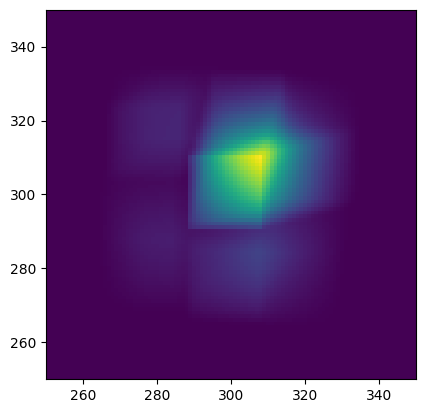

In [18]:
mat = np.zeros((500,500))
i = 300
j = 300
mat[i-10:i+10,j-10:j+10] = 1
ang = np.rad2deg(np.arctan2(i-250,j-250))
ker = rot(psf_px,ang,ang0)
ker = convolution.Kernel2D(array = ker)
im = convolution.convolve(mat,ker)

plt.imshow(im,origin='lower')
plt.xlim(i-50,i+50)
plt.ylim(j-50,j+50)